In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip
#!ls
#!rm -rf PetImages

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: PetImages/Dog/5523.jpg  

In [8]:
!ls /content

'MSR-LA - 3467.docx'   PetImages  'readme[1].txt'   sample_data


In [16]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print(fpath)
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.preprocessing import *

image_size = (180, 180)
batch_size = 32

datagen = ImageDataGenerator(
  validation_split=0.2)


train_gen = datagen.flow_from_directory(
    "PetImages",
    subset="training",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
)
val_gen = datagen.flow_from_directory(
    "PetImages",
    subset="validation",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
)

Found 18729 images belonging to 2 classes.
Found 4681 images belonging to 2 classes.


In [ ]:
images,labels = next(train_gen)
print(images.shape)

(32, 180, 180, 3)


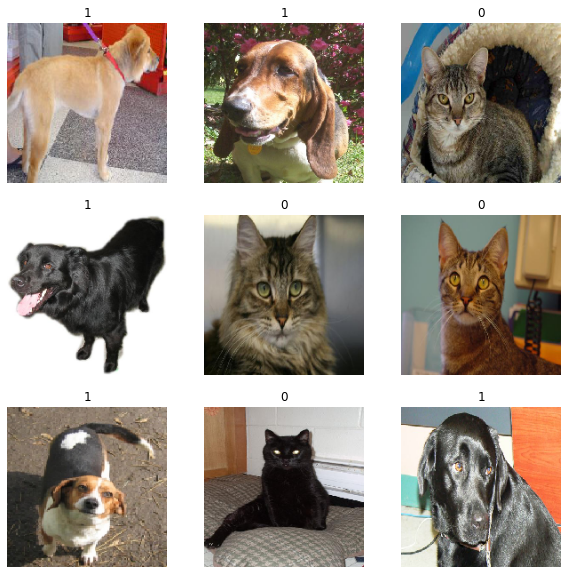

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
images,labels=next(train_gen)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

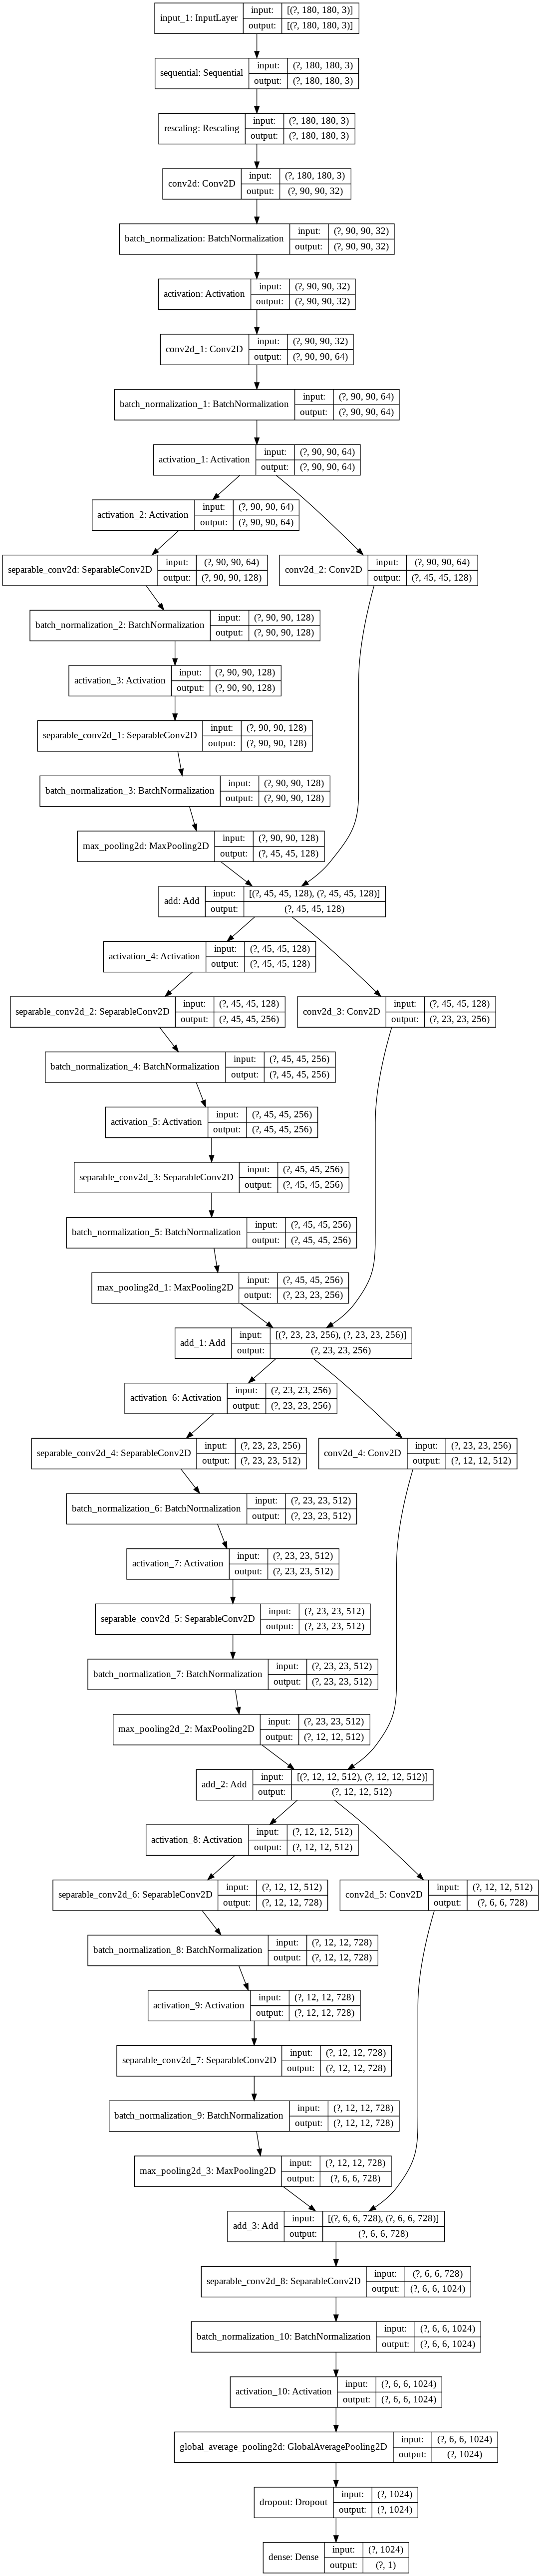

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_gen, epochs=epochs, callbacks=callbacks, validation_data=val_gen,
)

Epoch 1/50
586/586 [==============================] - 119s 203ms/step - loss: 0.6303 - accuracy: 0.6589 - val_loss: 0.5884 - val_accuracy: 0.6885
Epoch 2/50
586/586 [==============================] - 118s 201ms/step - loss: 0.4670 - accuracy: 0.7806 - val_loss: 0.5421 - val_accuracy: 0.7806
Epoch 3/50
586/586 [==============================] - 117s 200ms/step - loss: 0.3802 - accuracy: 0.8312 - val_loss: 0.6992 - val_accuracy: 0.6992
Epoch 4/50
586/586 [==============================] - 117s 200ms/step - loss: 0.3207 - accuracy: 0.8613 - val_loss: 0.4099 - val_accuracy: 0.8146
Epoch 5/50
586/586 [==============================] - 117s 200ms/step - loss: 0.2732 - accuracy: 0.8832 - val_loss: 0.2466 - val_accuracy: 0.9007
Epoch 6/50
586/586 [==============================] - 119s 202ms/step - loss: 0.2349 - accuracy: 0.9013 - val_loss: 0.7156 - val_accuracy: 0.7263
Epoch 7/50
586/586 [==============================] - 118s 201ms/step - loss: 0.2115 - accuracy: 0.9112 - val_loss: 0.3763 -

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 93.09 percent cat and 6.91 percent dog.
